
# Music Genre Classifications: Exploratory Data Analysis
The Kaggle data set [Music Genre Classifications](https://www.kaggle.com/harish24/music-genre-classification) has a breakdown of various spectral properties for different genres of music. We will try to answer the following questions:



*   Which spectral properties are closely related to one another?
*   Which genres are most and least similar according to their spectral properties?



For the first question we will define what the spectral properties are, and then examine the correlation between the different variables. To answer the second question we will train and test a logarithmic based classifier as well as a decision tree classifier and compare their ability to distinguish the various genres.

In [1]:
!pip install category_encoders==2.*;
!pip install pandas_profiling==2.*;

     |████████████████████████████████| 82 kB 381 kB/s 
     |████████████████████████████████| 245 kB 4.2 MB/s 
     |████████████████████████████████| 675 kB 48.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 4.7 MB 13.3 MB/s 
     |████████████████████████████████| 102 kB 70.1 MB/s 
     |████████████████████████████████| 812 kB 71.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=29cd9f3d2031ebeb734767bf70adbcfaf4160b86177e93db0ce034edd5ebeee2
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=4638b280f28623fb245c876da8fa3741c70164cb70039310d565257800716daf
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [66]:
# Load the file into a data frame
music = pd.read_csv("/content/Music Genre Classification Kaggle.csv")

# Display the first few rows and check for missing values
display(music.head())
num_null = music.isnull().sum().sum()
print("The number of missing values in the total dataframe is", num_null)

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351028,-6.376458,18.618876,-13.697912,15.344631,-12.285267,10.980492,-8.324325,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,35.874683,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903744,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,-13.987036,25.754763,-13.649585,11.629271,-11.780589,9.706443,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149012,-3.196314,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,22.153301,-32.489269,10.864513,-23.357929,0.503118,-11.805832,1.206805,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,blues


The number of missing values in the total dataframe is 0


We begin by looking at the head of our dataframe and check for missing values. We're lucky that there are no missing values so we do not have any NaN's to fill, but there are 26 different spectral properties given. Since we will be using simple models in this exploration let us first turn our attention to the variables we have to work with.



---


## Variables
First let us establish a working understanding of each of our variables (sources in hyperlinks):


### Definitions

* [Chroma feature](https://en.wikipedia.org/wiki/Chroma_feature) - Captures harmonic and melodic characteristics
* [Root Mean Square Energy (RMSE)](https://musicinformationretrieval.com/energy.html) - Roughly corresponds to how loud a given sound file is
* [Spectral Centroid](https://en.wikipedia.org/wiki/Spectral_centroid#:~:text=The%20spectral%20centroid%20is%20a,of%20brightness%20of%20a%20sound.) - Indicates where the center of the sound file's spectrum is
* [Spectral Bandwidth](https://devopedia.org/audio-feature-extraction) - The spectral range of interest around the centroid
* [Roll off](https://www.sweetwater.com/insync/rolloff/) - Amount of frequencies above and below the spectral bandwidth
* [Zero Crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate) - The rate at which a signal changes from negative to positive or vice versa
* [Mel-Frequency Cepstral Coefficients (MFCC1-20) ](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,collectively%20make%20up%20an%20MFC.&text=This%20frequency%20warping%20can%20allow,windowed%20excerpt%20of)%20a%20signal.) - Collectively give a certain representation of an audio clip

---

### Correlations

The first thing to notice about the description of our variables is the definitions of some of them seem to depend on one another. Namely the Spectral Centroid/Bandwidth and roll off. The models we will be working with in this notebook are logarithmic classification and decision trees. Since both models are sensative to correlated variables, we wish to remove the strongest correlations. 

Let us find them:

In [8]:
# Correlation matrices are symmetric matrices so the (2,1) entry is the same as the (1,2) entry
# Correlation matrices also have a diagonal of 1's indicating each column is strongly correlated with itself
# We first build a function that specifies the values we do not want

def get_redundant_pairs(df):
    # Selects diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


In [9]:
def get_top_abs_correlation(df, n):
    """Returns the n highest correlated columns of a given dataframe"""
    au_corrs = df.corr().abs().unstack()
    # Using the above function we avoid duplicate entries and self correlations
    labels_to_drop = get_redundant_pairs(df)
    au_corrs = au_corrs.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corrs[0:n]

In [10]:
# We remove the non numeric columns of our dataframe and return the highest correlations
get_top_abs_correlation(music.drop(columns = ['filename', 'label']), 10)

spectral_centroid   rolloff               0.979633
spectral_bandwidth  rolloff               0.956194
spectral_centroid   mfcc2                 0.940171
rolloff             mfcc2                 0.934305
spectral_centroid   spectral_bandwidth    0.904438
spectral_bandwidth  mfcc2                 0.896660
spectral_centroid   zero_crossing_rate    0.874755
mfcc6               mfcc8                 0.837294
mfcc8               mfcc10                0.811826
mfcc10              mfcc12                0.808013
dtype: float64

As we expected from their definitions the spectral bandwidth, spectral centroid, and roll off columns appear to be highly correlated. We also note that MFCC2 appears to be highly correlated with these columns, and decide to only keep one of these columns (note spectral centroid was originally kept because it had the highest correlation with the other dropped variables.)

In [11]:
music = music.drop(
    columns=["spectral_bandwidth", "rolloff", "mfcc2", "zero_crossing_rate"],
)

In [12]:
get_top_abs_correlation(music.drop(columns = ['filename', 'label']), 10)

mfcc6   mfcc8     0.837294
mfcc8   mfcc10    0.811826
mfcc10  mfcc12    0.808013
rmse    mfcc1     0.807260
mfcc7   mfcc9     0.787006
mfcc5   mfcc7     0.766312
mfcc11  mfcc13    0.761336
mfcc8   mfcc12    0.759870
mfcc12  mfcc14    0.734650
mfcc13  mfcc15    0.733808
dtype: float64

Running our correlation function after removing the redundant columns we see that the highest correlation between columns is .83 which we will accept for now. We also note that now of our 10 highest correlations 8 of them are between various MFC coefficients. Since the correlation is not too strong we will leave this be for now, but we shall keep it in mind as we continue exploring the data.

## Building The Model


Now that we have an understanding of what our spectral properties are, and their relationships, let us turn to answering the question of what genres are most and least similar to one another.


### Visualization

To begin this process, let us first visualize the remaining variables we have broken down by genre. We can make initial predictions based on any trends we may notice.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


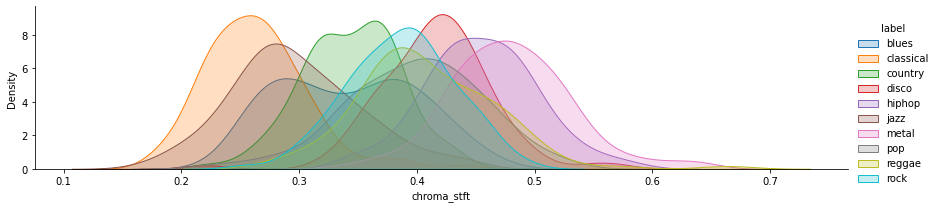

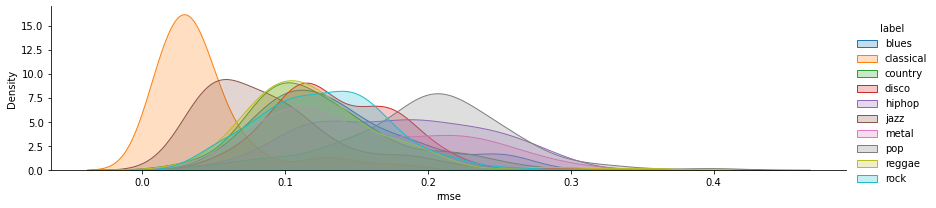

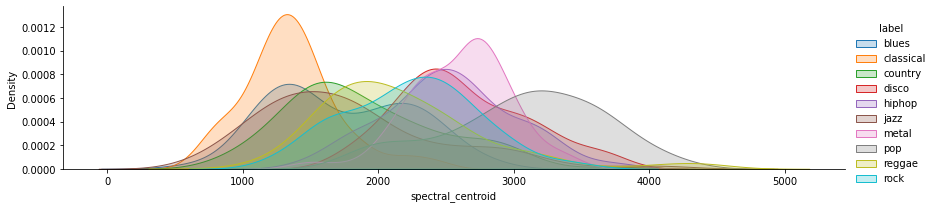

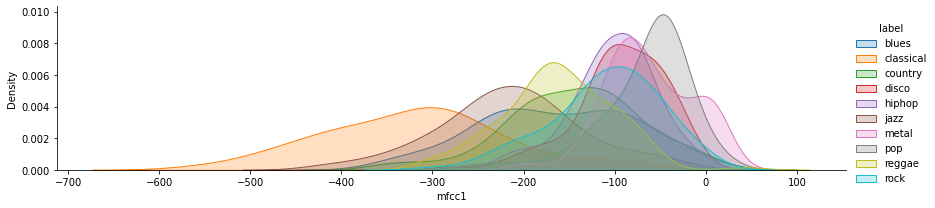

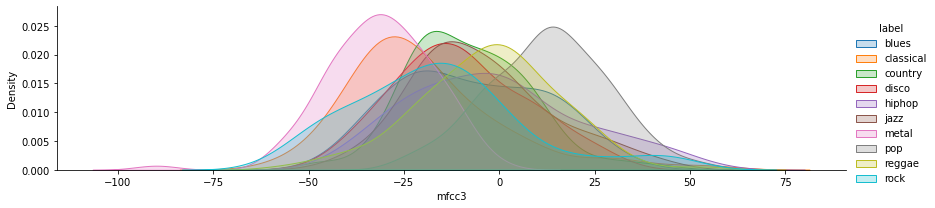

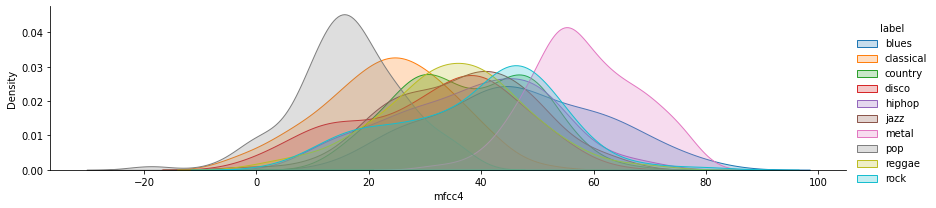

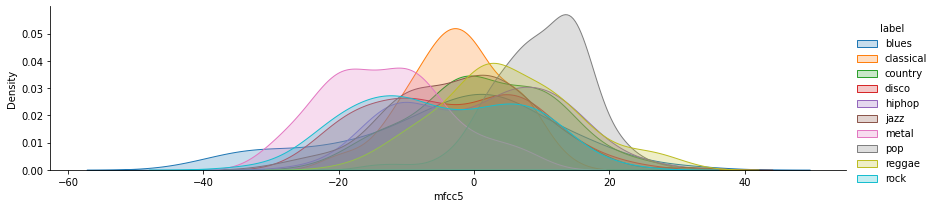

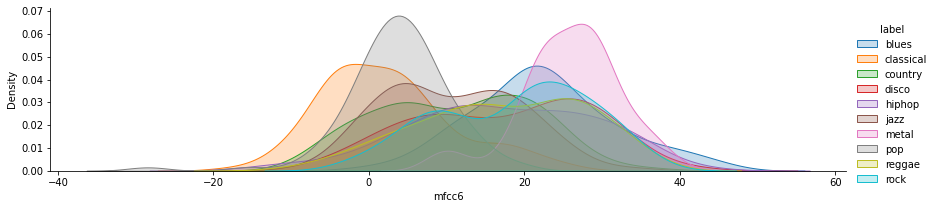

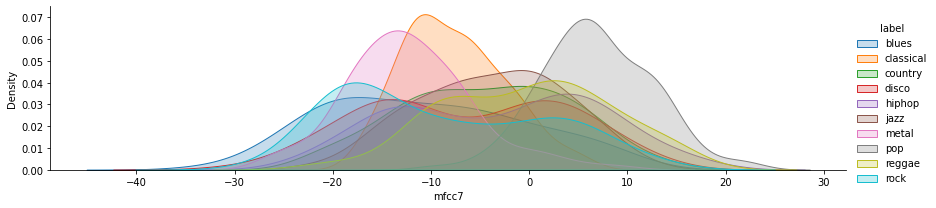

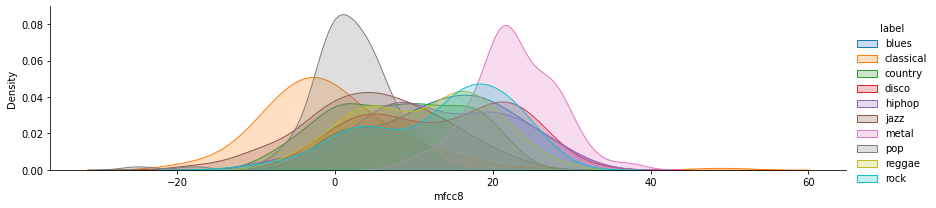

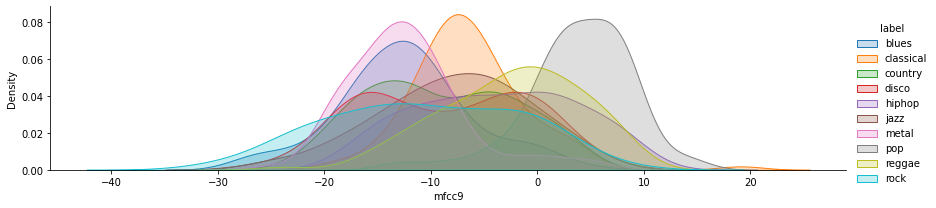

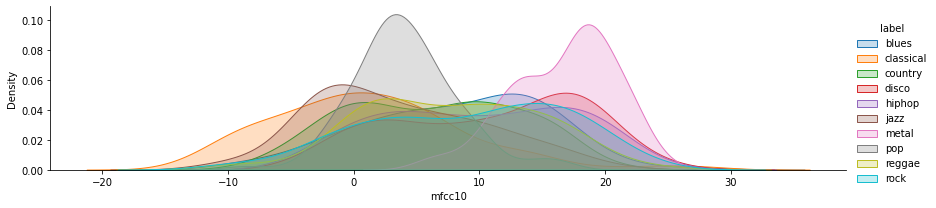

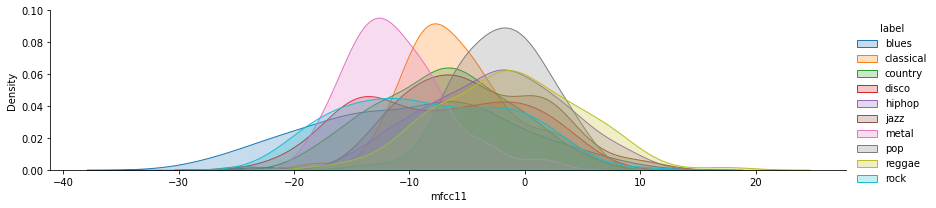

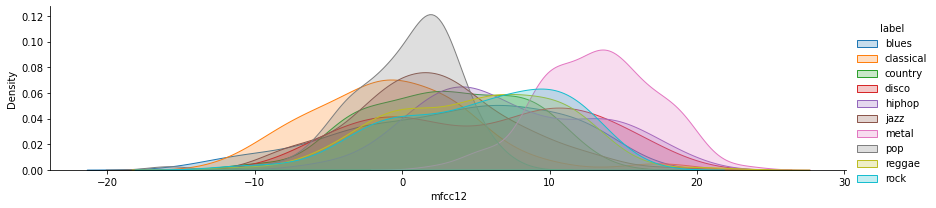

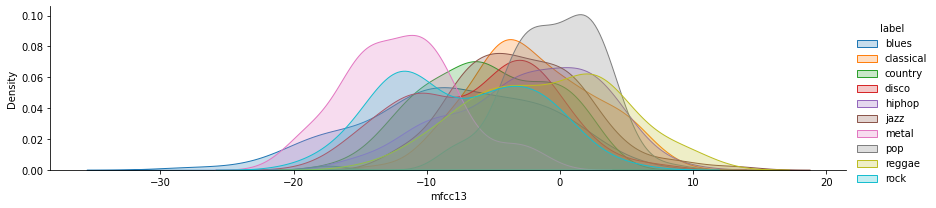

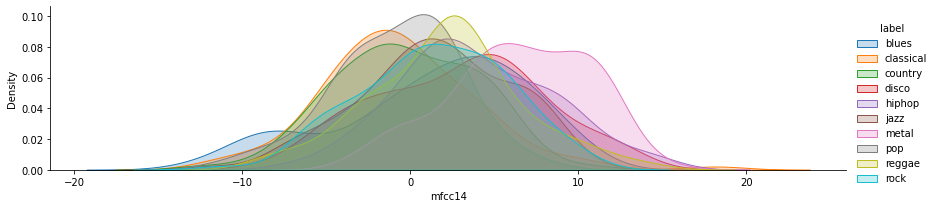

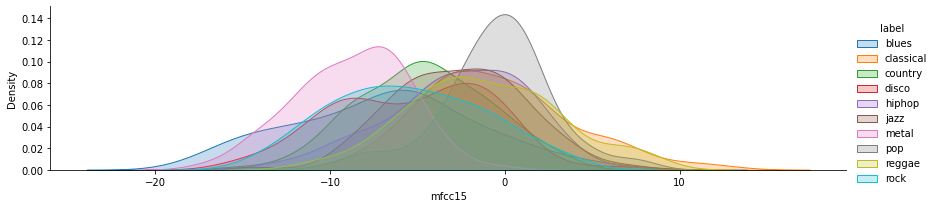

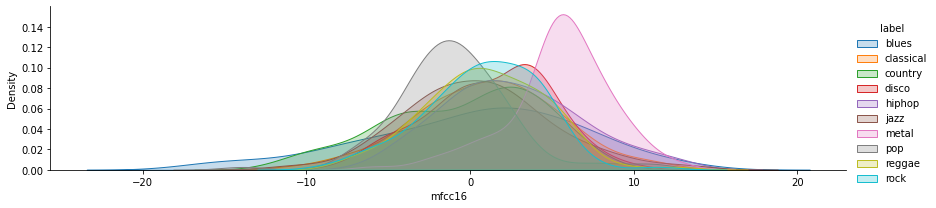

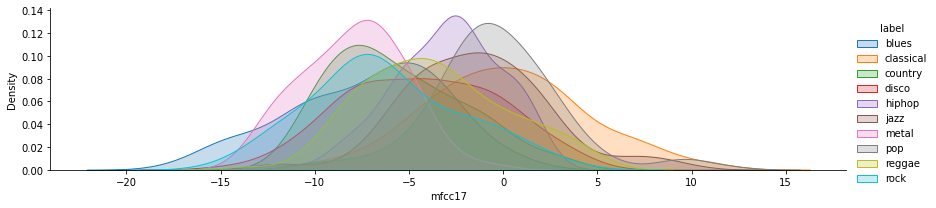

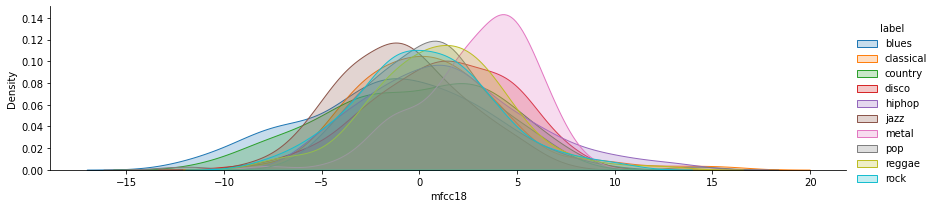

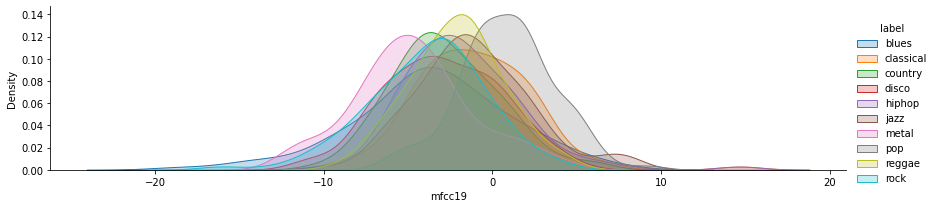

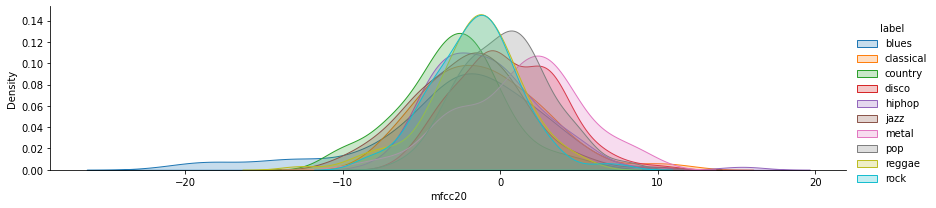

In [13]:
cols = list(music.select_dtypes(include="number").columns)

for col in cols:
    fig = sns.FacetGrid(music, hue="label", aspect=4)

    fig.map(sns.kdeplot, col, shade=True)

    oldest = music[col].max()

    fig.add_legend()

Some initial observations:
* In the first 5 graphs the classical distribution is far away from most of our other genres. Particularly it is furthest from pop and/or metal
* For most of the rest of the distributions pop and metal are far away from one another
* The peaks of each genre distributions appear to slowly converge for the higher MFC Coefficients

We will not remove any more columns for now, but we will return to some of these observations in our analysis.

### Genre Analysis

Now we will look at the ability of these two models to accurately distinguish between the different combinations of genres. We begin this by first organizing our data by genre.



In [67]:
# Replace genre labels with integers and make a reference list
music["genre_index"] = pd.factorize(music["label"])[0]
genres_index = list(music.label.unique())

# Drop redundant columns conveying the genre
music.drop(columns=["filename", "label"], inplace=True)

In [15]:
# Create dfs for each genre
def genre_df_maker(df):
    genres = [
        "Blues",
        "Classical",
        "Country",
        "Disco",
        "Hiphop",
        "Jazz",
        "Metal",
        "Pop",
        "Reggae",
        "Rock",
    ]
    genre_dict = {
        genre: df.loc[df["genre_index"] == idx] for idx, genre in enumerate(genres)
    }
    return genre_dict

In [16]:
# Functions that compute test statistics
def model_genre_results(genre_dict, model, target):
    # Set our target variable
    log_results = {}

    for i, (genre1, genre1_df) in enumerate(genre_dict.items()):
        for j, (genre2, genre2_df) in enumerate(genre_dict.items()):
            if i >= j:
                continue
            # A double loop that fits a logarithmic classifier
            df_concat = pd.concat([genre1_df, genre2_df])

            y = df_concat[target]
            X = df_concat.drop(columns=target)

            # Split the data into train test
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            # The log model
            model_log = make_pipeline(
                OneHotEncoder(use_cat_names=True),
                StandardScaler(),
                model,
            )

            model_log.fit(X_train, y_train)

            # Results are recorded in the dictionary
            log_results[f"{genre1} {genre2}"] = (
                accuracy_score(y_train, model_log.predict(X_train)),
                accuracy_score(y_test, model_log.predict(X_test)),
            )
    log_results = pd.DataFrame.from_dict(log_results)

    return log_results


def log_genre_results(genre_dict, target="genre_index"):
    return model_genre_results(genre_dict, LogisticRegression(), target=target)


def dt_genre_results(genre_dict, target="genre_index"):
    return model_genre_results(
        genre_dict, DecisionTreeClassifier(random_state=42), target=target
    )

We have functions that build logarithmic and decision tree models so we can compare our genres using different methods. Let us compare these models under different subsets of our data frame, beginning with all remaining variables.

In [17]:
def music_tester(music):
    genre_dict = genre_df_maker(music)
    log = log_genre_results(genre_dict)
    dt = dt_genre_results(genre_dict)
    result = pd.concat([log, dt])
    result.index = [
        "log model accuracy score for training",
        "log model accuracy score for test",
        "dt accuracy score for training",
        "dt accuracy score for test",
    ]
    return result

Let us first consider the dataframe as we last left it:

In [47]:
full_df_test = music_tester(music).T
full_df_test.mean()

log model accuracy score for training    0.947222
log model accuracy score for test        0.909444
dt accuracy score for training           0.999861
dt accuracy score for test               0.848889
dtype: float64

We will save enterpretation of these results for the conclusion, and for now just focus on the models' performance. 

It appears that both of our models have fairly high accuracy for the test sets. The log test performs similarly on the training and test data, so the model is likely a good fit. The Decision tree model has a near perfect score on the training data, and the worst performance across both models on the test data. This means our decision tree is likely overfitting the training data, and not as good of a model as it could be.

Let us investigate the observations we made during the correlation/observation sections to see if we can get better performances.

---

Decision trees are good at finding subtle relationships between variables, but in the same vein are more sensative to highly correlated columns than log models. As we recall the highest correlation after our pruning was .83, so let us try removing a few more highly correlated columns to see if we can bring up our decision tree's performance.

The next two most correlated columns (with other columns, not each other) were the MFC Coefficients 7 and 8, so let us see how our models do when we drop them.

In [46]:
lowest_corr_df = music_tester(music.drop(columns=["mfcc7", "mfcc8"])).T
lowest_corr_df.mean()

log model accuracy score for training    0.943472
log model accuracy score for test        0.910000
dt accuracy score for training           0.999861
dt accuracy score for test               0.860000
dtype: float64

We can see that dropping these correlated columns has improved both models performance on the test sets. 

---

Let us see if we can improve performance with our last observation. Recall our  observation that the histograms of the last three MFC Coefficients seemed to converge, and thus may not be lending much information to distinguishing the genres.

In [48]:
no_high_mfccs_df = music_tester(music.drop(columns=["mfcc18", "mfcc19", "mfcc20"])).T
no_high_mfccs_df.mean()

log model accuracy score for training    0.941806
log model accuracy score for test        0.912778
dt accuracy score for training           0.999861
dt accuracy score for test               0.851111
dtype: float64

Here we see that both models continue to do equally well on the training data. Our logarithmic model's performance on the test set has steadily improved as we've removed more columns. The decision tree, as expected, performed the best when we removed the highly correlated columns, though its performance here is still better than the original dataset.

Since the performance of both models has steadily imrpoved as we have removed columns, let us try one final test of removing both the correlated, and the high coefficient columns.

In [49]:
stripped_down_df = music_tester(music.drop(columns=["mfcc18", "mfcc19", "mfcc20", "mfcc7", "mfcc8"])).T
stripped_down_df.mean()

log model accuracy score for training    0.937222
log model accuracy score for test        0.910556
dt accuracy score for training           0.999861
dt accuracy score for test               0.848889
dtype: float64

We see we may have over stripped our data. Our log model's performance has dropped for the first time, and the decision tree model's accuracy on the test set has returned to its baseline performance.

Since this is exploratory data analysis we will accept our best performance of each model and move into final discussions. We will discuss possible ways to improve our models in the future work section.

# Conclusions

As we delve into our final discussion, let us look at the test results for our best performing models:



In [88]:
best_performance = pd.concat([no_high_mfccs_df['log model accuracy score for test'], lowest_corr_df['dt accuracy score for test']], axis= 1)
best_performance.tail(15)

,log model accuracy score for test,dt accuracy score for test
Hiphop Jazz,0.950,0.900
Hiphop Metal,0.900,0.825
Hiphop Pop,0.950,0.900
Hiphop Reggae,0.725,0.675
Hiphop Rock,0.875,0.725
Jazz Metal,1.000,0.925
Jazz Pop,0.925,0.950
Jazz Reggae,0.950,0.850
Jazz Rock,0.875,0.875
Metal Pop,1.000,1.000


Since the largets spread of accuracy is from (about) 70% all the way up to 100%, let us choose the threshold of:
* Two genres are similar if both of our models were unable to achieve above a 85% accuracy
* Two genres are distinct if both of our models were able to achieve at least 85% accuracy.

In [74]:
similar_genres = best_performance.loc[(best_performance['log model accuracy score for test'] <= .85) & (best_performance['dt accuracy score for test'] <= .85)].index.tolist()
similar_genres

['Blues Country',
 'Blues Rock',
 'Country Jazz',
 'Country Reggae',
 'Country Rock',
 'Disco Hiphop',
 'Disco Rock',
 'Hiphop Reggae',
 'Reggae Rock']

A few thoughts on our similar genres:
* Most of the genres that appear here had a lot of overlap in the distributions
* Very few had distinct peaks in our visualizations

In [75]:
distinct_genres = best_performance.loc[(best_performance['log model accuracy score for test'] > .85) & (best_performance['dt accuracy score for test'] > .85)].index.tolist()
distinct_genres

['Blues Classical',
 'Blues Jazz',
 'Blues Metal',
 'Blues Pop',
 'Classical Country',
 'Classical Disco',
 'Classical Hiphop',
 'Classical Metal',
 'Classical Pop',
 'Classical Reggae',
 'Classical Rock',
 'Country Disco',
 'Country Hiphop',
 'Country Metal',
 'Country Pop',
 'Disco Pop',
 'Hiphop Jazz',
 'Hiphop Pop',
 'Jazz Metal',
 'Jazz Pop',
 'Jazz Rock',
 'Metal Pop',
 'Metal Reggae',
 'Metal Rock',
 'Pop Rock']

A few thoughts on our distinct genres:

* Our initial observations that classical was easily distinguished is seen here
* Our next note that pop and metal appeared to be different is reflected here as well
* Some may be surprised by both model's ability to distinguish between rock and metal given the large overlap between the two genres. This likely comes from selecting our two best models. Both models struggled with this classification in the majority of the tests so removing the specific columns that held each model back likely helped distinguish these two

Now let us see if our criteria left out any entries.

In [84]:
remainder = best_performance.drop(similar_genres).drop(distinct_genres)
remainder

,log model accuracy score for test,dt accuracy score for test
Blues Disco,0.900,0.850
Blues Hiphop,0.975,0.775
Blues Reggae,0.875,0.825
Classical Jazz,0.950,0.850
Disco Jazz,0.900,0.850
Disco Metal,0.900,0.850
Disco Reggae,0.925,0.775
Hiphop Metal,0.900,0.825
Hiphop Rock,0.875,0.725
Jazz Reggae,0.950,0.850


It appears that our log model was able to  accurately differentiate some genres that our decision tree model could not. This means there is still some more work that could be done to try and bring our log model's accuracy up to that of the log model on these.

While there is surely more work that can be done here, we have at least answered our original questions to some degree of satisfaction. Let us call this a stopping point for our work here, and address things we may do if we return to this project with stronger tools.

## Future Work

With a project as open ended as this one, one is never truly done but we were able to answer our inital questions fairly well. Should anyone happen accross this notebook, or author return to it, and want to build upon the work done herein some next steps that could be taken are:

* Exploring the data more! There is always more refining of our data that can be done. We did a rough exploration until we found a working model, but in no way were we thorough in making sure we had the best data to train our models on
* Instead of comparing genres pairwise as we did here, we could instead test one genre vs the rest at once
* Using a random forest instead of a decision tree. While a decision tree is a decent classifier, it has tendency to overfit training data and generalize poorly to test data as we saw. Using a random forest could be a solution to this
* Gradient boosting. We could train a gradient boosted tree model to fit the data as well. Gradient boosting decision trees have the same benefits of random forests but tend to out perform  them
